# Query matching
In this notebook I will query images from the cornershop dataset and we will look for simular embeddings in the embedding gallary. The goal is to end up with a top 5,10 of matches.

In [1]:
%matplotlib inline

In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid #imagegrids for visualizing the top 10 matches
import PIL
from PIL import Image
from load_vissl_model import load_model #self defined function to reconstruct a vissl model
from pathlib import Path

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



## Loading embedding gallary
First we'll load a vissl model to use for inference:

In [3]:
#Specify the model below! Possible options are:
#"rotnet", "jigsaw", "moco", "simclr" and "swav"
model_name = "rotnet"
model = load_model(model_name, verbose=True)

#checking for the best device to run model on
device = torch.device("cpu") 
# if(torch.cuda.is_available()):
#     device = torch.device("cuda")
#     model.to(device) #move model to gpu
print(f"using {device} device", end="\n\n")

In function load_model()
Train config at (relative path from vissl/...):
validation/rotnet_full/train_config.yaml
SSL pretrained weights at:
/home/olivier/Documents/master/mp/checkpoints/sku110k/rotnet_full/model_final_checkpoint_phase104.torch


/home/olivier/Documents/master/mp/.venv/lib/python3.8/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive config/validation/rotnet_full/train_config.yaml in pkg://configs.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)


Model rotnet was succusfully build
Weights for model rotnet succesfully loaded
using cpu device



Now let's load the embedding gallary for this model:

In [4]:
#Gallary is stored in data folder with model_name as subfolder
dir = Path("data/" + model_name)

#Load torch stack of features
fts_stack = torch.load(dir / "embedding_gallary.torch")
print(f"fts_stack has shape {fts_stack.shape}")
print(f"Minimum value {fts_stack.min()}\nMaximum value {fts_stack.max()}")
print(f"4 example tensors from this stack:\n{fts_stack[0:5]}", end="\n\n")

#Load torch stack of normalized features
fts_stack_norm = torch.load(dir / "embedding_gallary_norm.torch")
print(f"fts_stack_norm has shape {fts_stack_norm.shape}")
print(f"Minimum value {fts_stack_norm.min()}\nMaximum value {fts_stack_norm.max()}")
print(f"4 example tensors from this stack:\n{fts_stack_norm[0:5]}", end="\n\n")

#load label list
labels = list()
with open(dir / "embedding_gallary_labels.txt", "r") as f:
    labels = f.read().splitlines()
    print(f"labels list has length "+ str(len(labels)))
    print(f"4 examples from the label list are: {labels[0:4]}")

fts_stack has shape torch.Size([1643, 2048])
Minimum value 0.0
Maximum value 0.8728528618812561
4 example tensors from this stack:
tensor([[0.2150, 0.2665, 0.1761,  ..., 0.3124, 0.2011, 0.3125],
        [0.2778, 0.2248, 0.2405,  ..., 0.2993, 0.2309, 0.3611],
        [0.2062, 0.1784, 0.1928,  ..., 0.2180, 0.1578, 0.2812],
        [0.0829, 0.1635, 0.1168,  ..., 0.2811, 0.1833, 0.2025],
        [0.0972, 0.2343, 0.0653,  ..., 0.1450, 0.1096, 0.1145]])

fts_stack_norm has shape torch.Size([1643, 2048])
Minimum value 0.0
Maximum value 0.09552113711833954
4 example tensors from this stack:
tensor([[0.0170, 0.0211, 0.0139,  ..., 0.0247, 0.0159, 0.0247],
        [0.0220, 0.0178, 0.0190,  ..., 0.0237, 0.0183, 0.0286],
        [0.0195, 0.0169, 0.0183,  ..., 0.0207, 0.0150, 0.0267],
        [0.0089, 0.0175, 0.0125,  ..., 0.0300, 0.0196, 0.0216],
        [0.0125, 0.0301, 0.0084,  ..., 0.0186, 0.0141, 0.0147]])

labels list has length 1643
4 examples from the label list are: ['CawstonDry', 'CawstonD

## Quering an image from CornerShop

In [5]:
#import the feature extraction method from the script that made the gallary
from embedding_gallary import extract_features

Collect the images:

In [6]:
#path where images are stored 
CornerShop = Path("/home/olivier/Documents/master/mp/CornerShop/CornerShop/crops")
img_paths = CornerShop.glob("*/*.jpg")
query_idx = -1

Query idx is 3, labels[3]=MinuteMaidAppelPerzik
Reading image at /home/olivier/Documents/master/mp/CornerShop/CornerShop/crops/MinuteMaidAppelPerzik/p1_0011.jpg


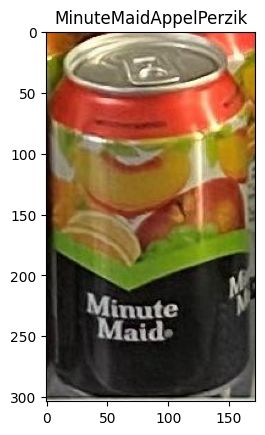

In [10]:
img_path = next(img_paths) #cycing trough the cornershop image dataset
query_idx+=1 #next label in list
label = img_path.parent.stem #extracting foldername as label for image
print(f"Query idx is {query_idx}, labels[{query_idx}]={labels[query_idx]}")
print(f"Reading image at {img_path}")
img = Image.open(img_path)
plt.title(label)
plt.imshow(img)

Calculate the embedding with the vissl model:

In [11]:
img_fts = extract_features(img_path,model,verbose=True)
print(f"feature vector has shape {img_fts.shape}")
print(f"The embedding vector looks like this: {img_fts}")

Features extracted have the shape: torch.Size([2048])
feature vector has shape torch.Size([2048])
The embedding vector looks like this: tensor([0.0829, 0.1635, 0.1168,  ..., 0.2811, 0.1833, 0.2025])


In [12]:
#calulating the normalized features for our image
norm = img_fts.norm(dim=0,keepdim=False)
img_fts_norm = img_fts / norm

## Matching the query embedding to the gallary
In summary we have:
- The calculated embedding `img_fts` of our query image (as a torch.Tensor)
- The calculated normalized embedding `img_fts_norm` of our query image (as a torch.Tensor)
- The `query_idx`, which represents the index of our query embedding in the gallary embedding
- The `label` containing the ground truth for classification
- The embedding gallary `fts_stack` (as a torch.Tensor)
- The normalized embedding gallary `fts_stack_norm` (as a torch.Tensor)

Our goal is to match the query embedding to the best match in the gallary

In [13]:
#Converting our gallary to numpy arrays
fts_stack_np = fts_stack.numpy()
fts_stack_norm_np = fts_stack_norm.numpy()
#Converting our img_fts to numpy array
img_fts_np = img_fts.numpy()
img_fts_norm_np = img_fts_norm.numpy()
print("Conversion to numpy arrays succesfull")
print(f"dtype fts_stack_np={type(fts_stack_np)}\ndtype fts_stack_norm_np={type(fts_stack_norm_np)}")
print(f"dtype img_fts_np={type(img_fts_np)}")
print(f"dtype img_fts_norm_np={type(img_fts_norm_np)}")

Conversion to numpy arrays succesfull
dtype fts_stack_np=<class 'numpy.ndarray'>
dtype fts_stack_norm_np=<class 'numpy.ndarray'>
dtype img_fts_np=<class 'numpy.ndarray'>
dtype img_fts_norm_np=<class 'numpy.ndarray'>


In [14]:
#visualization for the matching results:
def show_top10(top10):
    """ Makes an imagegrid of the top 10 matches:
        Args:
            top10 : Array with indicis of the top10 matching embeddings from the gallary
    """
    #visualizing the top10
    top10_matches = [list(CornerShop.glob("*/*.jpg"))[i] for i in top10]
    imgs = [Image.open(top10_matches[i]) for i in range(len(top10_matches))]
    #creating matlab figure
    fig = plt.figure(figsize=(10., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 5),  # creates 2x5 grid of axes
                     axes_pad=0.4,  # pad between axes in inch.
                     )
    i=1
    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.set_title(f"Match #{i}")
        ax.imshow(im)
        i+=1

    plt.show()

In [15]:
def calc_top10(sim_vector, reverse_sort=True):
    """Extracts the top10 matches out of a simularity vector.
    This is done by performing an argsort on sim_vector.
    The result of argsort is returned.
    
    Args:
        sim_vector(np.array): simularity vector containing simularity scores with the query
        reverse_sort(boolean): True if higher simularity scores are considered better, False
        if lower simularity scores are considered better (e.g. euclidian distance, lower is better)
    """
    argsort_vector = np.argsort(sim_vector, kind="quicksort")
    if reverse_sort:
        #reverse order so best match is at the front of the array
        argsort_vector = argsort_vector[::-1] 
    #print("Top 10 matches with inner product as metric are:\n")
    top10 = argsort_vector[0:10]
    #print(top10, end="\n\n")
    print("Top10 label matches:")
    for rank,label_idx in enumerate(top10):
        print(f"{rank+1}.{labels[label_idx]}")
    print(f"\nGroud Truth = {label}")
    return top10

### Inner product (ip)

In [16]:
#Calulating the inner product of the query and all the embeddings in the gallary
print(f"img_fts {img_fts_np.shape} x fts_stack.T {fts_stack_np.T.shape}")
sim_vector_ip =  np.matmul(img_fts_np, fts_stack_np.T) #multiply the img_fts_np with every embedding in the gallary 
#The simularity vector contains a score that expresses how simular the query embedding 
#for each embedding in the embedding gallary
print(f"The sim_vector_ip looks like this: {sim_vector_ip}")
print(f"min     {sim_vector_ip.min()}")
print(f"max     {sim_vector_ip.max()}")
print(f"avg     {sim_vector_ip.mean()}")
print(f"std dev {sim_vector_ip.std()}")

img_fts (2048,) x fts_stack.T (2048, 1643)
The sim_vector_ip looks like this: [112.43474  112.67336   93.451225 ...  86.584274 138.99474   97.9289  ]
min     59.68101119995117
max     182.2252960205078
avg     102.96305084228516
std dev 24.74429702758789


In [17]:
top10 = calc_top10(sim_vector_ip)

Top10 label matches:
1.JupilerBlik35,5cl
2.GiniBlik6x33cl
3.CocaColaLightFles500ml
4.SpaBlauw50cl
5.EristoffRed
6.GiniBlik33cl
7.MayTeaPecheBlanche4x33cl
8.JupilerBlik35,5cl
9.FantaOrangeNoCalFles
10.FantaOrangeBlik6x330ml

Groud Truth = MinuteMaidAppelPerzik


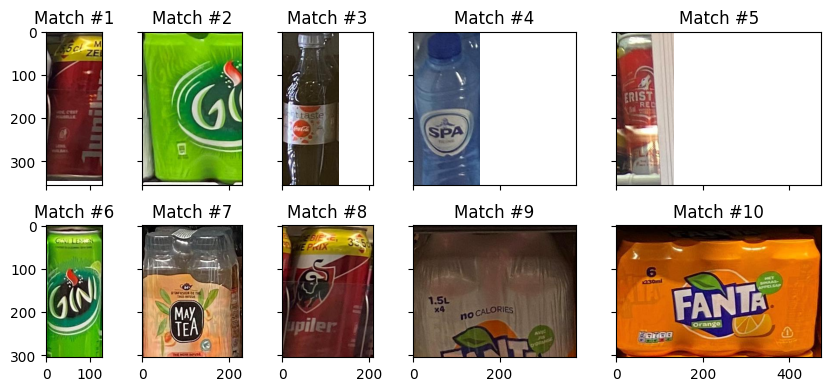

In [18]:
show_top10(top10=top10)

### Cosine simularity (cosim)

In [19]:
#Calulating the cosine simularity of the query and all the embeddings in the gallary
print(f"img_fts {img_fts_norm_np.shape} x fts_stack.T {fts_stack_norm_np.T.shape}")
sim_vector_cosim =  np.matmul(img_fts_norm_np, fts_stack_norm_np.T)  
print(f"The sim_vector_ip looks like this: {sim_vector_cosim}")
print(f"min     {sim_vector_cosim.min()}")
print(f"max     {sim_vector_cosim.max()}")
print(f"avg     {sim_vector_cosim.mean()}")
print(f"std dev {sim_vector_cosim.std()}")

img_fts (2048,) x fts_stack.T (2048, 1643)
The sim_vector_ip looks like this: [0.95020825 0.95244586 0.9465706  ... 0.9597941  0.9511304  0.95744514]
min     0.927264928817749
max     1.0
avg     0.9500263333320618
std dev 0.007260974962264299


In [20]:
top10 = calc_top10(sim_vector_cosim)

Top10 label matches:
1.MinuteMaidAppelPerzik
2.MayTeaPecheBlanche1L
3.VolvicHibiscusTea37cl
4.CarrefourBioAnanassap
5.MayTeaFramboos1L
6.DashRaspberries
7.CarrefourBioAnanassap
8.Monster44
9.CocaColaZeroFles500ml
10.VittelWater1L

Groud Truth = MinuteMaidAppelPerzik


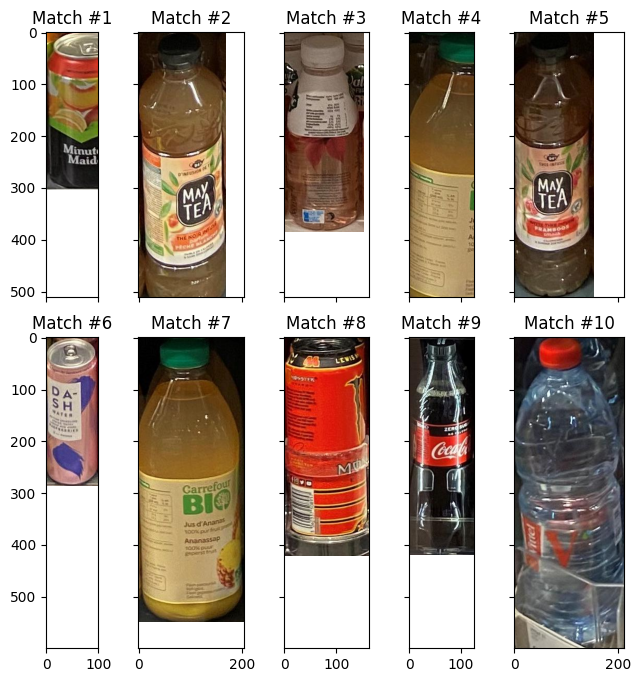

In [21]:
show_top10(top10=top10)

### Euclidian distance

In [22]:
eucl_dist = [] 
for gallary_embedding in fts_stack_np:
    #d(image_galary_embed, gallary_embedding)=euclid distance
    d_img_galemb = np.sqrt(np.sum(np.power(img_fts_np - gallary_embedding, 2))) 
    eucl_dist.append(d_img_galemb)
    
sim_vector_eucl_dist = np.array(eucl_dist)
print(f"The sim_vector_eucl_dist looks like this: {sim_vector_eucl_dist}")
print(f"min     {sim_vector_eucl_dist.min()}")
print(f"max     {sim_vector_eucl_dist.max()}")
print(f"avg     {sim_vector_eucl_dist.mean()}")
print(f"std dev {sim_vector_eucl_dist.std()}")


The sim_vector_eucl_dist looks like this: [4.7482123 4.6897917 3.4580162 ... 2.707524  7.305166  3.340491 ]
min     0.0
max     12.601824760437012
avg     4.4917192459106445
std dev 1.9653044939041138


In [23]:
top10 = calc_top10(sim_vector_eucl_dist, reverse_sort=False)

Top10 label matches:
1.MinuteMaidAppelPerzik
2.Monster44
3.VolvicHibiscusTea37cl
4.CocaColaZeroFles500ml
5.VittelWater1L
6.CocaColaZeroFles500ml
7.MayTeaMureMyrtille1L
8.MayTeaPecheBlanche1L
9.AquariusRedPeachFles500ml
10.CocaColaFles500ml

Groud Truth = MinuteMaidAppelPerzik


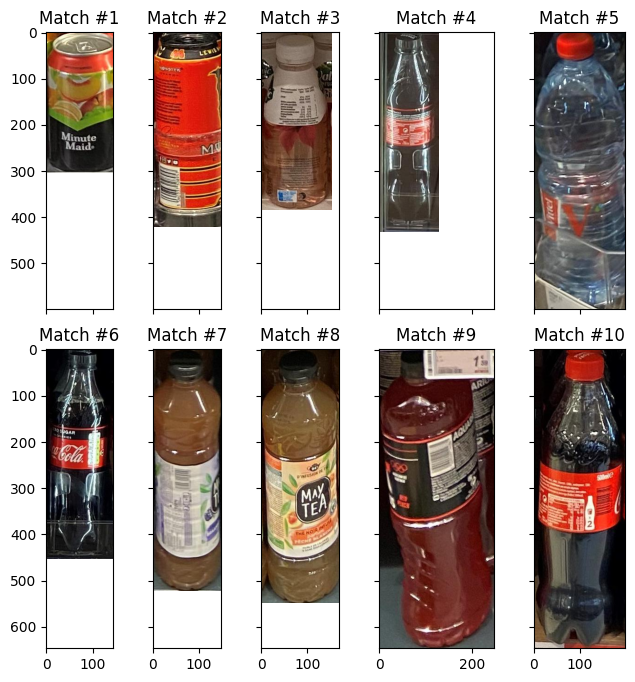

In [24]:
show_top10(top10=top10)

### Euclidian distance (normalized features)

In [25]:
eucl_dist_norm = [] 
for gallary_embedding in fts_stack_norm_np:
    #d(image_galary_embed, gallary_embedding)=euclid distance
    d_img_galemb = np.sqrt(np.sum(np.power(img_fts_norm_np - gallary_embedding, 2))) 
    eucl_dist_norm.append(d_img_galemb)
    
sim_vector_eucl_dist_norm = np.array(eucl_dist_norm)
print(f"The sim_vector_eucl_dist looks like this: {sim_vector_eucl_dist_norm}")
print(f"min     {sim_vector_eucl_dist_norm.min()}")
print(f"max     {sim_vector_eucl_dist_norm.max()}")
print(f"avg     {sim_vector_eucl_dist_norm.mean()}")
print(f"std dev {sim_vector_eucl_dist_norm.std()}")

The sim_vector_eucl_dist looks like this: [0.31556842 0.30839616 0.32689306 ... 0.28356823 0.3126332  0.29173458]
min     0.0
max     0.38140514492988586
avg     0.3152327239513397
std dev 0.023987773805856705


In [26]:
top10 = calc_top10(sim_vector_eucl_dist_norm, reverse_sort=False)

Top10 label matches:
1.MinuteMaidAppelPerzik
2.MayTeaPecheBlanche1L
3.VolvicHibiscusTea37cl
4.CarrefourBioAnanassap
5.MayTeaFramboos1L
6.DashRaspberries
7.CarrefourBioAnanassap
8.Monster44
9.CocaColaZeroFles500ml
10.VittelWater1L

Groud Truth = MinuteMaidAppelPerzik


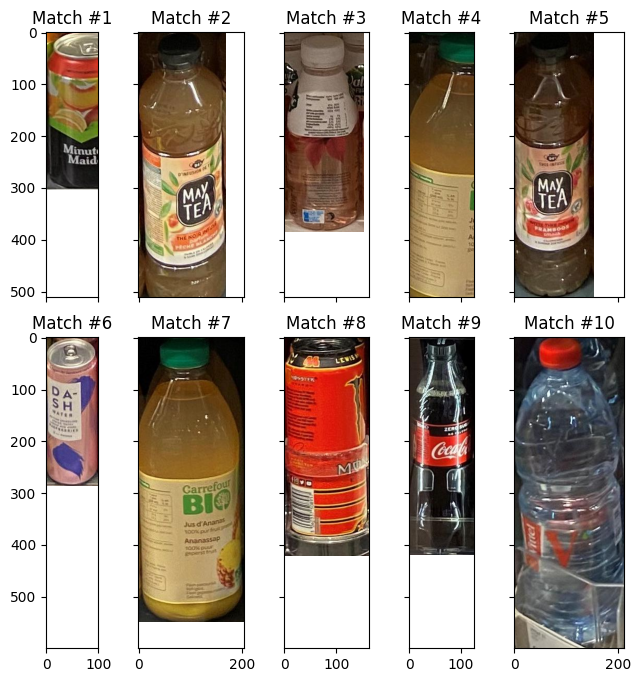

In [27]:
show_top10(top10=top10)